# TED: Inferential Statistics

__Assignment prompt__:  
At this point, you have obtained the data set for your Capstone project, cleaned and wrangled it into a form that's ready for analysis. It's now time to apply the inferential statistics techniques you have learned to explore the data. For example, are there variables that are particularly significant in terms of explaining the answer to your project question? Are there strong correlations between pairs of independent variables, or between an independent and a dependent variable? Write a short report (1-2 pages) on the inferential statistics steps you performed and your findings. Check this report into your github and submit a link to it. Eventually, this report can be incorporated into your Milestone report.

__Response__:  
Now that the data has been cleaned, we need to break the data into randomly-assigned train/test groups (70/30). After this, we can look at relationships between continuous non-word-vector variables that may be used in the model. From here, we'll identify the best non-word-vector model using 10-fold cross-validation on the Root Mean Squared Error. We'll then add in all of the word vectors and see if we can create a better-fitting model using the same approach. Finally, we'll see how these two models do on our test data and compare this with a simple intercept model.

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import itertools
from operator import itemgetter
from scipy.stats import spearmanr
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV


# Load cleaned dataset from pickled data
with open('TED_cleaned.pickle', 'rb') as file:
    df = pickle.load(file)   

# Separate data
predictors = ['duration', 'laughter', 'applause', 'event_type', 'has_music', 'has_dance', 'has_note']
for i in range(300):
    predictors.append(str(i))
X = df.loc[:, predictors]
y = df.loc[:, 'pos_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_catd = pd.get_dummies(X_train, columns=cats, drop_first=True)
X_catd_test = pd.get_dummies(X_test, columns=cats, drop_first=True)

## 1. Variable correlation
First, let's look at how our continuous predictive variables correlate with each other and with the output variable (__pos_pct__). We can accomplish this visually with a pairplot grid and look at Spearman's rho to check for correlation between continuous variables.

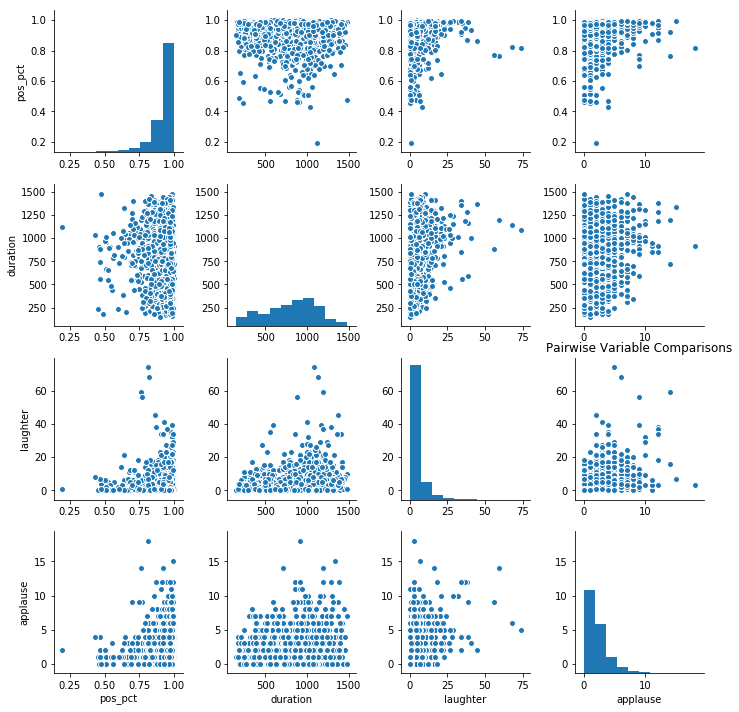

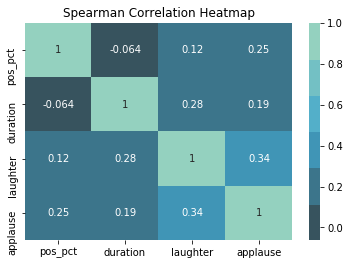

In [397]:
df_train = X_train.join(y_train)
cols = ['pos_pct', 'duration', 'laughter', 'applause']
_ = sns.pairplot(data=df_train.loc[:, cols])
_ = plt.title("Pairwise Variable Comparisons")
_ = plt.show()


df_corr = df_train.loc[:, cols].corr(method='spearman')
heat = sns.heatmap(df_corr, annot=True, cmap=sns.color_palette("GnBu_d"))
heat = plt.title("Spearman Correlation Heatmap")
heat = plt.show()

Both the visualizations and the Spearman's rho correlations show weak to no correlation between variable pairs.

---

## 2. Non-Word Regression Model Variable Selection (Training)

At this point, we should try to create a model that uses these variables so that we can see if adding in the word vectors can improve the results. To do this, we need to get the data into a form that our stats package can work with. We'll then run a backward variable selection method to choose the best model for the data. There are few enough columns that we can perform a grid search at this point.

In [398]:
def grid_once(x, y):
    """
    Helper function for cv_grid(). Performs grid search using negative mean squared error to score.
    Performs for normalized and non-normalized data.
    Returns list of mean and standard deviation over test scores for normalized and non-normalized data.
    """
    lm = LinearRegression()
    param_grid = {'normalize':[True,False]}
    grid = GridSearchCV(lm, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    grid.fit(x, y)
        
    return [[grid.cv_results_['mean_test_score'][0], grid.cv_results_['std_test_score'][0]], 
            [grid.cv_results_['mean_test_score'][1], grid.cv_results_['std_test_score'][1]]]

def cv_grid(x, y, cols, cats):   
    """
    Runs grid search over X and y, converting categorical columns on the fly. Returns normalized and
    non-normalized data results for each combination of variables.
    x: predictors (pandas DF)
    y: dependent variable (pandas DF or series)
    cols: all column names in x that should be used as predictors
    cats: all columns that should be split into dummy variables (drops first option for each)
    
    returns list of dictionaries for normed and non-normed means and standard deviations
    """
    count = 0
    norm_combos = dict()
    no_norm_combos = dict()    
    
    for i in range(1, len(cols)+1):        
        combos = itertools.combinations(cols, i)
        
        for combo in combos:
            cat_combo = set(combo).intersection(set(cats))
            if len(cat_combo):
                cat_x = pd.get_dummies(x.loc[:, combo], columns=list(cat_combo), drop_first=True)
                scores = grid_once(cat_x, y)
            else:
                scores = grid_once(x.loc[:, combo], y)
            
            norm_combos[count] = [combo]
            no_norm_combos[count] = [combo]
            norm_combos[count].append(scores[0][0])
            norm_combos[count].append(scores[0][1])
            no_norm_combos[count].append(scores[1][0])
            no_norm_combos[count].append(scores[1][1])

            count += 1
    
    return norm_combos, no_norm_combos

In [399]:
# Perform grid search for non-word vectors
cols = ['duration', 'laughter', 'applause', 'event_type', 'has_music', 'has_dance', 'has_note']
cats = ['event_type', 'has_music', 'has_dance', 'has_note']
normed_vars, no_normed_vars = cv_grid(X_train, y_train, cols, cats)

In [400]:
# Print results from grid search
sorted_results = sorted(no_normed_vars.items(), key=lambda x: x[1][1], reverse=True)
print("Root Mean Squared Error on Training Data:", np.sqrt(-sorted_results[0][1][1]))
print("Variables:", ', '.join(sorted_results[0][1][0]))

Root Mean Squared Error on Training Data: 0.08552542681057672
Variables: duration, applause, event_type


Our best model has a RMSE of 0.0855 on our training data using the variables __duration__, __applause__, and __event_type__. Let's make a model using the word vectors now.

---

## 3. Overall Regression Model Variable Selection (Training)

We were able to do a grid search when we had only a few variables to choose from. Now that we have over 300, it would take _quite_ a long time to fit all of the $2.187 $ __x__ $ 10^{99}$ models. Instead, we will use recursive feature elimination along with our 10-fold cross-validation approach. This method starts with all of the variables, then creates a model for each of the 10 cross-validations. The overall least important variable (or variables, if tied) are removed and the 10 models are created again. The model with the best mean score (negative mean squared error in this case) is chosen as the "best."

In [401]:
# Perform Recursive Feature Elimination (Cross-Validated)
model = RFECV(LinearRegression(), scoring='neg_mean_squared_error', cv=10)
fit_models = model.fit(X_catd, y_train)

best_vars = list()
for j in range(len(fit_models.ranking_)):
    if fit_models.ranking_[j] == 1:
        best_vars.append(X_catd.keys()[j])

In [402]:
scores = cross_val_score(LinearRegression(), X_catd.loc[:, fit_models.support_], y_train, cv=10, scoring='neg_mean_squared_error')
print("RMSE:", np.sqrt(-scores).mean())

RMSE: 0.07931892382996185


## 4. Model Comparisons (Testing)

Now that we have our models, we can test them against each other. We should also create an intercept-only model to see how much better our predictions are than just guessing the mean.

In [403]:
# Intercept Model
int_array_train = np.array([1]*1640).reshape(-1,1)
intercept = LinearRegression().fit(int_array_train, y_train)
int_train_predict = intercept.predict(int_array_train)
print("Intercept Training RMSE:", np.sqrt(metrics.mean_squared_error(y_train, int_train_predict)))

int_array_test = np.array([1]*704).reshape(-1,1)
int_test = intercept.predict(int_array_test)
int_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, int_test))
print("Intercept Testing RMSE:", int_test_rmse)

Intercept Training RMSE: 0.08693712059445693
Intercept Testing RMSE: 0.08275277687569858


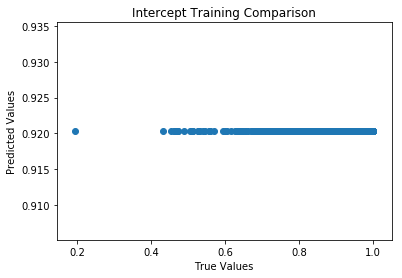

In [412]:
plt.scatter(y_train, int_train_predict)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Intercept Training Comparison")
plt.show()

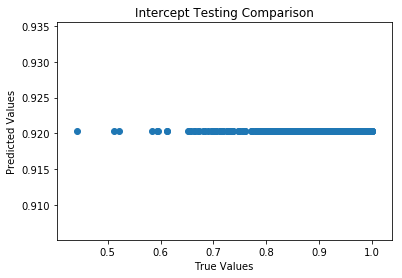

In [413]:
plt.scatter(y_test, int_test)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Intercept Testing Comparison")
plt.show()

In [406]:
# Non-Word Model
noword_cols = ['duration', 'applause'] + [col for col in list(X_catd.keys()) if col.startswith('event')]
noword_model = LinearRegression().fit(X_catd.loc[:, noword_cols], y_train)
noword_scores = cross_val_score(LinearRegression(),
                               X_catd.loc[:, noword_cols],
                               y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
print("Non-Word Training RMSE:", np.sqrt(-noword_scores).mean())

noword_test = noword_model.predict(X_catd_test.loc[:, noword_cols])
noword_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, noword_test))
print("Non-Word Test RMSE:", noword_test_rmse)
print("% Better than Intercept-only:", "{0}%".format(round(-100*(1-int_test_rmse/noword_test_rmse), 4)))

Non-Word Training RMSE: 0.0843381674921508
Non-Word Test RMSE: 0.0813249662190985
% Better than Intercept-only: 1.7557%


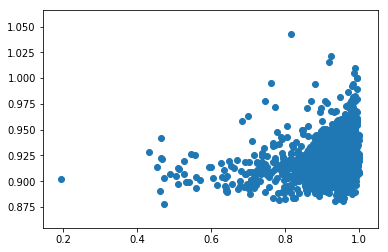

In [407]:
plt.scatter(y_train, noword_model.predict(X_catd.loc[:, noword_cols]))
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Non-Word Training Comparison")
plt.show()

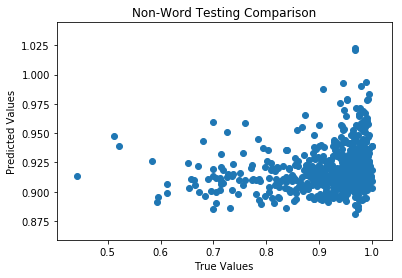

In [414]:
plt.scatter(y_test, noword_test)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Non-Word Testing Comparison")
plt.show()

In [409]:
# Overall Model
overall_model = LinearRegression().fit(X_catd.loc[:, fit_models.support_], y_train)
overall_scores = cross_val_score(LinearRegression(), 
                                 X_catd.loc[:, fit_models.support_], 
                                 y_train, 
                                 cv=10, 
                                 scoring='neg_mean_squared_error')
print("Overall Train RMSE:", np.sqrt(-overall_scores).mean())

overall_test = overall_model.predict(X_catd_test.loc[:, fit_models.support_])
overall_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, overall_test))
print("Overall Test RMSE:", overall_test_rmse)
print("% Better than Intercept-only:", "{0}%".format(round(-100*(1-int_test_rmse/overall_test_rmse), 4)))
print("% Better than Non-Word:", "{0}%".format(round(-100*(1-noword_test_rmse/overall_test_rmse), 4)))

Overall Train RMSE: 0.07931892382996185
Overall Test RMSE: 0.07961094888511576
% Better than Intercept-only: 3.9465%
% Better than Non-Word: 2.153%


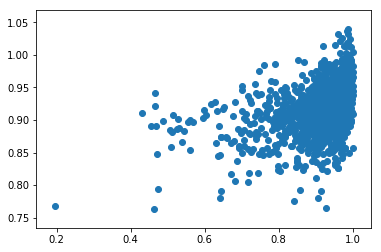

In [410]:
plt.scatter(y_train, overall_model.predict(X_catd.loc[:, fit_models.support_]))
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Overall Training Comparison")
plt.show()

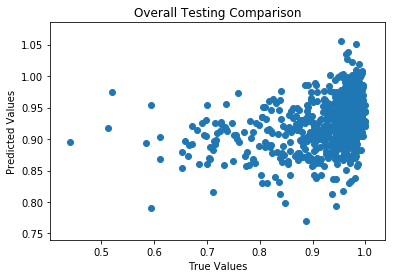

In [415]:
plt.scatter(y_test, overall_test)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Overall Testing Comparison")
plt.show()

## 5. Interpretation

The above results show us that our Overall model does a better job predicting scores than our Intercept-only and Non-Word models, but just barely. The graphs show us that in both training and testing, lower-valued scores are consistently given much higher ratings than they should be, and in some cases, ratings are given a percentage higher than 100%. Since the purpose of this model is to determine whether or not a video should be posted online, and it consistenly over-rates poorly-performing videos, it should not be used.